# Project:Sarcasm Classification

### Pre read notes

1.   Keras in Tensforflow on Google colab (GC) has been used for this exercise.
2. The project is for sarcasm classification and this belongs to 'many to one' type of problem in NLP.
3. However Bi-directional LSTM is used for model build and evaluation as given in project descripton.
4. For text preprocessing, stopwords removal is not done, primarily because  this results in drop in model accuracy. For the sake of simplicity and better readability the detailed evaluation with stopwords removal done is not produced in this notebook. However the comparision of results with stopwords removed and without stopwords not removed showed a drop in accuracy (apprx - 4 %). Hence stopwords removal is not done in the version submitted as part of this workbook.
5. As part of overall model tuning, the text preprocessing - headline cleaning was tweaked to assess the impact of various cleaning options (e.g removal of text inside brackets, with and without contraction mapping, with and without removing stopwords etc.)
6. Glove 6B 200 vector size is used for weight matrix pre population and the model is trained.
7. Since the lables are not balanced, balancing is done using SMOTE technique and model training is done on balanced training data set.
8. Bi-Directional LSTM is initially modelled (named as Base Model) and as part of hyper parameter tuning 3 alternatives (named as Model Variant A,B and C) were considered to tune the model performance. The comparative results of the model output is given at the end as part of evaluation.
9. Commentaries have been given to the code ( inside the code block using # to give context to the calculation being done; as well as using the text block to give note on logical section grouping, approach , observations and final summary.



In [0]:
%tensorflow_version 2.x

### Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# libraries for basic utility functions , array / dataframes handling 
import os 
import time
from zipfile import ZipFile
import numpy as np
import pandas as pd

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# libraries for text processing
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

# libraries for mounting google drive for using GC
from google.colab import drive

# libraries for preprocessing, model building, and evaluation 
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Bidirectional, GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow import random
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
print ('Tensorflow version:',tf.__version__)

Tensorflow version: 2.2.0-rc3


## Set up drive and folder

In [3]:
# mounting the drive on Google Colab
drive.mount('/content/drive')

# changing the directory to point to project folder
os.chdir('/content/drive/My Drive/AIML/Projects/NLP2')
project_path = '/content/drive/My Drive/AIML/Projects/NLP2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# creating data frame to capture evaluation output of all models
df_result = pd.DataFrame(columns=['Model','Variant','Accuracy','MCC','CM','Class0-Precision','Sensitivity',\
                                        'Class0-F1','Class1-Precision','Specificity','Class1-F1'])

## Load the dataset 

In [5]:
# reading json file 
source_file = project_path +'/Sarcasm_Headlines_Dataset.json'
mydata = pd.read_json(source_file,lines=True)

# printing first few rows to review the data
mydata.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Analyze the dataset 

In [6]:
# understanding column datatypes , number of columns,rows 
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
# EDA for attributes of type category
mydata.select_dtypes(include=['object']).describe(include='all')

,article_link,headline
count,26709,26709
unique,26708,26602
top,https://www.huffingtonpost.comhttp://nymag.com...,the 20 funniest tweets from women this week
freq,2,10


In [0]:
# dropping rows with duplicate headline
mydata.drop_duplicates(subset=['headline'],inplace=True)

In [9]:
# EDA for attributes of type category ( after dropping duplicates)
mydata.select_dtypes(include=['object']).describe(include='all')

,article_link,headline
count,26602,26602
unique,26602,26602
top,https://www.huffingtonpost.com/entry/after-the...,new freestyle rap card game is bringing hip-ho...
freq,1,1


Values,Count,Mix%
0,14951,56.200000
1,11651,43.800000


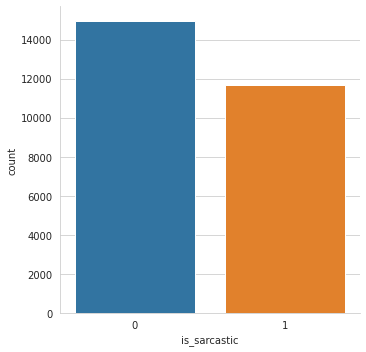

In [10]:
# analyzing the mix of labels in the given dataset
curattr = 'is_sarcastic'
sns.catplot(x=curattr, kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(5, 5)
Item=[]
for i in mydata[curattr].unique():
    Item.append([
        i,
        len(mydata[mydata[curattr] == i]),
        round((len(mydata[mydata[curattr] == i])/len(mydata[curattr]))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%']) 



1.   Labels seem to be imbalanced.
2.   Number of headlines with non sarcastic comments are more than headlines with sarcastic comments.



In [11]:
# dropping column that is not relevant for further analysis
mydata.drop('article_link',axis=1,inplace=True)

# printing few records after dropping the column
mydata.sample(5)

,headline,is_sarcastic
2516,proof that apple watch owners are desperate to...,0
2652,another boxing hall of fame induction ends wit...,1
15206,study: you have hpv,1
21626,ridiculous bat vs. pipe road rage battle gets ...,0
13848,shelling from royal caribbean's m.s. 'allure' ...,1


In [12]:
# printing few headlines to read the full text along with the label
for i in range(5):
  print("Headline #",i+1)
  print('is_sarcastic flag:',mydata.is_sarcastic[i])
  print(mydata.headline[i])
  print("\n")

Headline # 1
is_sarcastic flag: 0
former versace store clerk sues over secret 'black code' for minority shoppers


Headline # 2
is_sarcastic flag: 0
the 'roseanne' revival catches up to our thorny political mood, for better and worse


Headline # 3
is_sarcastic flag: 1
mom starting to fear son's web series closest thing she will have to grandchild


Headline # 4
is_sarcastic flag: 1
boehner just wants wife to listen, not come up with alternative debt-reduction ideas


Headline # 5
is_sarcastic flag: 0
j.k. rowling wishes snape happy birthday in the most magical way




In [13]:
# calculating the number of words in the headline and storing in separate column in the dataframe
mydata['headline_length'] = mydata['headline'].apply(lambda i:len(i.split()) )

# printing few rows to check the result
mydata.head(5)

,headline,is_sarcastic,headline_length
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


Values,Count,Mix%
10,3479,13.080000
9,3295,12.390000
11,3194,12.010000
8,2833,10.650000
12,2635,9.910000
7,2326,8.740000
13,1863,7.000000
6,1720,6.470000
14,1280,4.810000
5,1129,4.240000


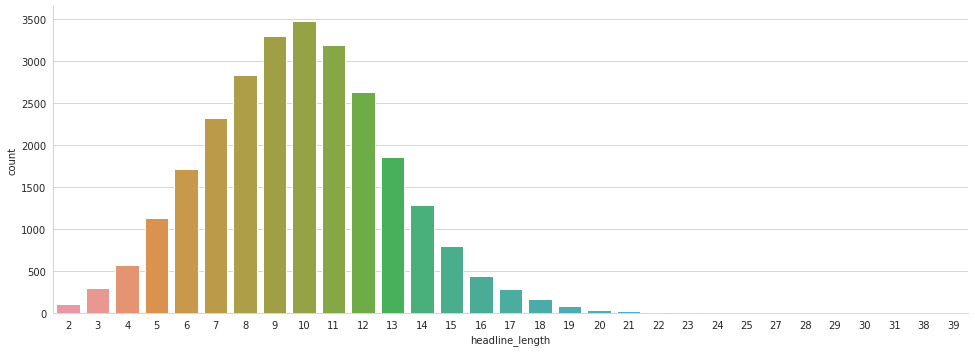

In [14]:
# analyzing the distribution of headline length
curattr = 'headline_length'
sns.catplot(x=curattr, kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)

# printing top headline length frequencies along with mix%
Item=[]
for i in mydata[curattr].unique():
    Item.append([
        i,
        len(mydata[mydata[curattr] == i]),
        round((len(mydata[mydata[curattr] == i])/len(mydata[curattr]))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%']) 



1.   Highest count of observation is for headline length 10.
2.   Though maximum headline length is 39, this seems more of outlier.
3.   Headline length up to 20 would cover 99.5% of the dataset.




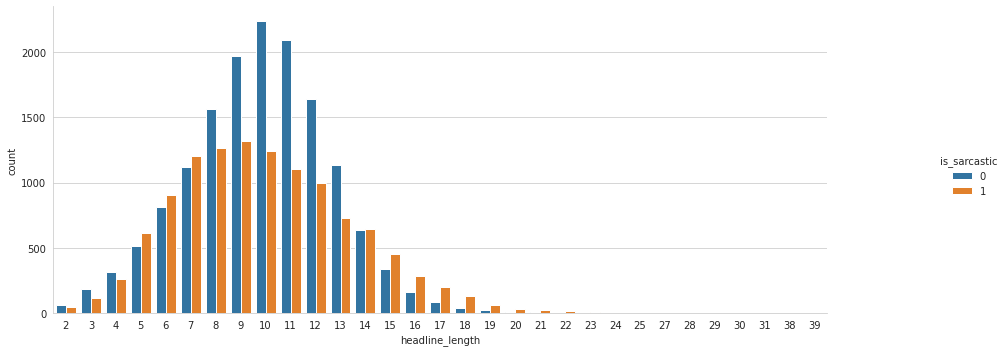

In [15]:
# analyzing the distribution of headline length - split between sarcasic headlines and non sarcastic headlines
curattr = 'headline_length'
sns.catplot(x=curattr, kind="count",hue="is_sarcastic",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)



1.   As noted initially,the data set has more data on non sarcastic headlines (class 0) than sarcastic headlines(class 1).
2.   While most of the non sarcastic headlines are of length 10, most of the sarcastic headlines are of length 9.
3.   If the headline length is more than 14, it is more likely to be sarcastic in nature.


In [16]:
# printing the maximum length of headline
print('Maximum length of headline:',mydata.headline_length.max())

Maximum length of headline: 39


## Text preprocessing 

In [0]:
# setting up contraction mapping dictionary
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [18]:
# setting up stopwords and removing 'no', 'not' from the list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# creating function to clean the headlines text by performing several transformations like converting to lower text, removing html tags etc.
def text_cleaner(text,num):
    # convert to lower case
    newString = text.lower()
    # remove html tags  
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub('"','', newString)
    # contraction mapping 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # remove apostrophe   
    newString = re.sub(r"'s\b","",newString)
    # remove anything other than alphabetic 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    # remove stopwords based on input parameter and split
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # remove short words    
    for i in tokens:
        if len(i)>1:                                                
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
# storing cleaned headline in a separate column in the dataframe. 
# stopwords not removed and hence parameter passed as 1 for text_cleaner
mydata['cleaned_headline']=mydata['headline'].map(lambda x: text_cleaner(x,1))

# calculating the length of cleaned headline
mydata['cleaned_headline_length'] = mydata['cleaned_headline'].apply(lambda x:len(x.split()) )

In [21]:
# printing few records in the dataframe to compare the results of text cleaning and impact on headline length
mydata.head(5)

,headline,is_sarcastic,headline_length,cleaned_headline,cleaned_headline_length
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sues over secret bl...,12
1,the 'roseanne' revival catches up to our thorn...,0,14,the roseanne revival catches up to our thorny ...,14
2,mom starting to fear son's web series closest ...,1,14,mom starting to fear son web series closest th...,14
3,"boehner just wants wife to listen, not come up...",1,13,boehner just wants wife to listen not come up ...,14
4,j.k. rowling wishes snape happy birthday in th...,0,11,rowling wishes snape happy birthday in the mos...,10


In [22]:
# printing full text (post and pre cleaning) along with label for few rows of data
for i in range(5):
  print("Headline #",i+1)
  print('is_sarcastic flag:',mydata.is_sarcastic[i])
  print('Original headline:',mydata.headline[i])
  print('Cleaned headline:',mydata.cleaned_headline[i])
  print("\n")

Headline # 1
is_sarcastic flag: 0
Original headline: former versace store clerk sues over secret 'black code' for minority shoppers
Cleaned headline: former versace store clerk sues over secret black code for minority shoppers


Headline # 2
is_sarcastic flag: 0
Original headline: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned headline: the roseanne revival catches up to our thorny political mood for better and worse


Headline # 3
is_sarcastic flag: 1
Original headline: mom starting to fear son's web series closest thing she will have to grandchild
Cleaned headline: mom starting to fear son web series closest thing she will have to grandchild


Headline # 4
is_sarcastic flag: 1
Original headline: boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Cleaned headline: boehner just wants wife to listen not come up with alternative debt reduction ideas


Headline # 5
is_sarcastic flag: 0
Original headline: j.k. 

Values,Count,Mix%
10,3497,13.150000
9,3343,12.570000
11,3137,11.790000
8,2970,11.160000
12,2555,9.600000
7,2325,8.740000
13,1794,6.740000
6,1755,6.600000
14,1189,4.470000
5,1151,4.330000


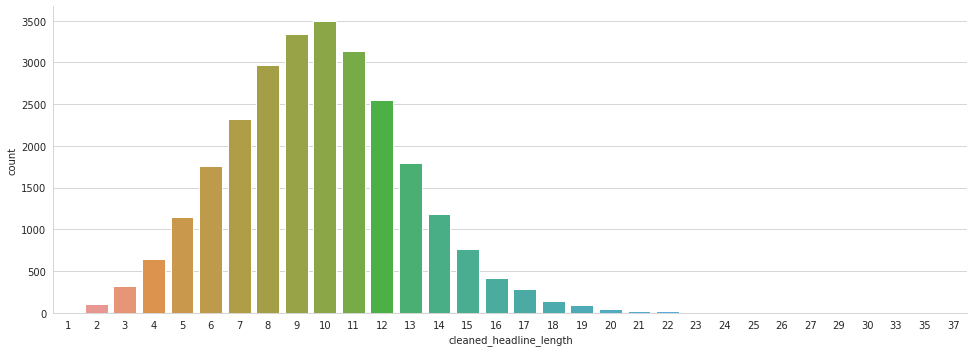

In [23]:
# analyzing the distribution of cleaned headline length
curattr = 'cleaned_headline_length'
sns.catplot(x=curattr, kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)

# printing top cleaned headline length frequencies along with mix%
Item=[]
for i in mydata[curattr].unique():
    Item.append([
        i,
        len(mydata[mydata[curattr] == i]),
        round((len(mydata[mydata[curattr] == i])/len(mydata[curattr]))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%']) 


1.   Highest count of observation is for headline length 10.
2.   Though maximum headline length is 37, this seems more of outlier.
3.   Headline length up to 20 would cover 99.5% of the dataset.

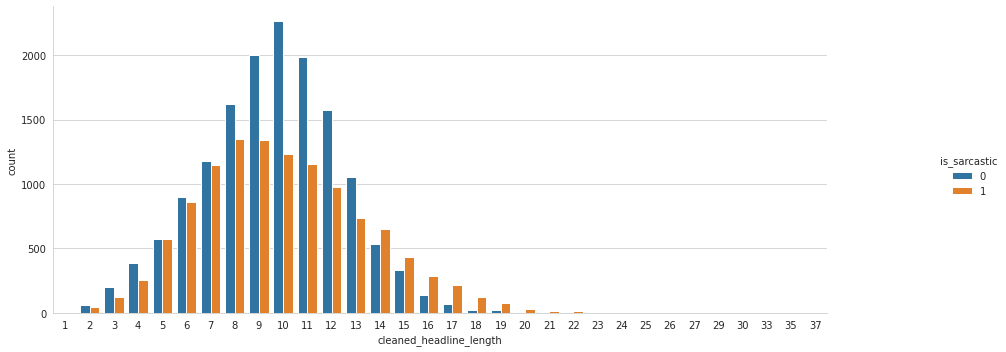

In [24]:
# analyzing the distribution of cleaned headline length - split between sarcasic headlines and non sarcastic headlines
curattr = 'cleaned_headline_length'
sns.catplot(x=curattr, kind="count",hue="is_sarcastic",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)


1.   As noted initially,the data set has more data on non sarcastic headlines (class 0) than sarcastic headlines(class 1).
2.   While most of the non sarcastic headlines are of length 10, most of the sarcastic headlines are of length 8 or 9.
3.   If the headline length is more than 13, it is more likely to be sarcastic in nature.

In [25]:
# printing the maximum length of cleaned headline
print('Maximun length of cleaned headline:',mydata.cleaned_headline_length.max())

Maximun length of cleaned headline: 37


In [26]:
# dropping columns headline length,cleaned headline length and headline
mydata.drop('headline_length',axis=1,inplace=True)
mydata.drop('cleaned_headline_length',axis=1,inplace=True)
mydata.drop('headline',axis=1,inplace=True)

# renaming columns 'cleaned headline' as 'headline' for further use in the model
mydata.rename(columns={'cleaned_headline': 'headline'}, inplace=True)

# printing few rows from the updated dataframe
mydata.head(5)

,is_sarcastic,headline
0,0,former versace store clerk sues over secret bl...
1,0,the roseanne revival catches up to our thorny ...
2,1,mom starting to fear son web series closest th...
3,1,boehner just wants wife to listen not come up ...
4,0,rowling wishes snape happy birthday in the mos...


## Apply Keras Tokenizer 

In [0]:
# setting up parameters 
max_features = 10000
maxlen = 20
embedding_size = 200

In [0]:
# initializing tokenizer and fitting on headline ( cleaned one)
tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ', char_level=False, oov_token=None, document_count=0)
tokenizer.fit_on_texts(mydata.headline)
word_index = tokenizer.word_index


In [0]:
# creating word dictionary
word_dict = {}
word_dict =tokenizer.word_counts

In [30]:
# priting first 20 items in the word dict
list(word_dict.items())[:20]

[('former', 106),
 ('versace', 1),
 ('store', 57),
 ('clerk', 11),
 ('sues', 17),
 ('over', 483),
 ('secret', 92),
 ('black', 267),
 ('code', 19),
 ('for', 3314),
 ('minority', 15),
 ('shoppers', 3),
 ('the', 5390),
 ('roseanne', 3),
 ('revival', 11),
 ('catches', 14),
 ('up', 840),
 ('to', 8244),
 ('our', 177),
 ('thorny', 3)]

In [0]:
# sorting the dictionary based on value count
word_dict_sorted = {k: v for k, v in sorted(word_dict.items(), key=lambda x: x[1],reverse=True)}

In [32]:
# printing top 20 word and id
list(word_dict_sorted.items())[:20]

[('to', 8244),
 ('of', 5630),
 ('the', 5390),
 ('in', 4233),
 ('for', 3314),
 ('is', 2560),
 ('on', 2429),
 ('and', 1932),
 ('with', 1800),
 ('trump', 1683),
 ('not', 1534),
 ('new', 1519),
 ('man', 1385),
 ('from', 1206),
 ('at', 1202),
 ('you', 1145),
 ('it', 1063),
 ('about', 1054),
 ('by', 896),
 ('this', 886)]

In [33]:
# printing bottom 20 word and id
list(word_dict_sorted.items())[-20:]

[('eel', 1),
 ('contributed', 1),
 ('manny', 1),
 ('underlined', 1),
 ('shithead', 1),
 ('opcw', 1),
 ('uninvestigated', 1),
 ('retreating', 1),
 ('massacred', 1),
 ('readin', 1),
 ('researchin', 1),
 ('writin', 1),
 ('drywall', 1),
 ('blowhole', 1),
 ('zimbabwe', 1),
 ('gonzalez', 1),
 ('breached', 1),
 ('hikes', 1),
 ('gourmet', 1),
 ('foodie', 1)]

In [34]:
# converting the text to sequence and padding based on the parameter length setup
X = tokenizer.texts_to_sequences(mydata['headline'])
X = pad_sequences(X, maxlen = maxlen,padding='post')
y = np.asarray(mydata['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26602
[ 295  623 3295 2248   46  351   92 2049    5 2541 8073    0    0    0
    0    0    0    0    0    0]
Number of Labels:  26602
0


In [35]:
#check the shape of dataset loaded
print('X dataset shape:',X.shape)
print('y dataset shape:',y.shape)

X dataset shape: (26602, 20)
y dataset shape: (26602,)


In [0]:
#creating train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10,shuffle=True)

In [37]:
#check the shape of dataset 
print('X_train dataset shape:',X_train.shape)
print('y_train dataset shape:',y_train.shape)
print('X_test dataset shape:',X_test.shape)
print('y_test dataset shape:',y_test.shape)

X_train dataset shape: (21281, 20)
y_train dataset shape: (21281,)
X_test dataset shape: (5321, 20)
y_test dataset shape: (5321,)


In [38]:
print('Distribution of lables in train dataset:',np.unique(y_train, return_counts=True))
print('Distribution of lables in test dataset:',np.unique(y_test, return_counts=True))

Distribution of lables in train dataset: (array([0, 1]), array([11889,  9392]))
Distribution of lables in test dataset: (array([0, 1]), array([3062, 2259]))


In [39]:
# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())
print('X_train_bal dataset shape:',X_train_bal.shape)
print('y_train_bal dataset shape:',y_train_bal.shape)

X_train_bal dataset shape: (23778, 20)
y_train_bal dataset shape: (23778,)


In [40]:
print('Distribution of lables in train dataset after balancing:',np.unique(y_train_bal, return_counts=True))

Distribution of lables in train dataset after balancing: (array([0, 1]), array([11889, 11889]))


## Get the Vocabulary size

In [41]:
# getting the vocabulary size
vocab_size = max(list(word_index.values())) + 1
print('Vocabulary size:',vocab_size)

Vocabulary size: 24868


## Get Glove Word Embeddings

In [0]:
# getting the glove 6B 200 vector weights - unziping the file
glove_file = project_path + "/glove.6B.zip"
with ZipFile(glove_file, 'r') as z:
  z.extractall()

## Get the Word Embeddings using Embedding file 

In [43]:
# getting the glove 6B 200 vector weights - reading the appropriate file and creating embedding dict
EMBEDDING_FILE = project_path + "/glove.6B.200d.txt"

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd


len(embeddings.values())

400000

## Create a weight matrix for words in training docs

In [44]:
# creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(24868, 200)


In [45]:
# printing embedding matrix for one sample 
print(embedding_matrix[1000])

[-0.31902     0.41731     0.4091     -0.32121     0.76563001 -0.23353
 -0.34880999 -0.41082001  0.12374     0.063786   -0.15181001  0.93636
 -0.57015002 -0.62808001 -0.1992      0.40572     0.042642    0.13705
  0.06591    -0.043851    0.069655    2.87310004  0.16744     0.40970001
  0.35512     0.50274003 -0.10088    -0.1604      0.41156    -0.34513
  0.48923999  0.77696002 -0.16249    -0.43176001 -0.037504    0.46752
 -0.17515001 -0.33526999  0.87905002 -0.23910999 -0.26163     0.31341001
 -0.18848    -0.031475    0.23863     0.25411001  0.81173998 -0.93597001
  0.56656998  0.54947001  0.4129      0.32429001  0.18373001  0.16601001
 -0.43178001  0.037353    0.13354     0.14155     0.26561001 -0.24286
  0.078027    0.28887001  0.11038     0.49634001 -0.27200001 -0.043012
  0.25192001  1.00460005 -0.013838    0.45131999  0.078007   -0.33074
 -0.17489     0.31711999  0.099553   -0.24447     0.62728     0.39636001
 -0.3425     -0.53052002  0.35253999 -0.26394999 -0.44080999  0.68396002
 

## Build LSTM classification Model

In [0]:
# common embedding parameters for the model
input_dim=vocab_size
output_dim=embedding_size
input_length=maxlen

# other common parameters for the model
seed=99
EPOCHS = 10
BATCH_SIZE = 100
lstm_out = 128
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
loss = 'binary_crossentropy'
metrics_model='accuracy'

### Bi-directional LSTM classification Model

In [47]:
# defining model - Bidirectional LSTM - Base model without any regularization

# clearing the session and seeding randomness
clear_session()
np.random.seed(seed)
random.set_seed(seed)

# define Base model
model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,weights = [embedding_matrix]))
#model.add(Embedding(input_dim, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

# compile Base model
model.compile(loss=loss,optimizer=optimizer, metrics=metrics_model) 

print('Model Summary - Base Model',end='\n\n')
print(model.summary())

Model Summary - Base Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           4973600   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,327,009
Trainable params: 5,327,009
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
238/238 - 18s - loss: 0.4639 - accuracy: 0.7726 - val_loss: 0.3239 - val_accuracy: 0.8600
Epoch 2/10
238/238 - 17s - loss: 0.2892 - accuracy: 0.8743 - val_loss: 0.2937 - val_accuracy: 0.8762
Epoch 3/10
238/238 - 17s - loss: 0.1801 - accuracy: 0.9278 - val_loss: 0.3400 - val_accuracy: 0.8630
Epoch 4/10
238/238 - 17s - loss: 0.0995 - accuracy: 0.9646 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 5/10
238/238 - 17s - loss: 0.0445 - accuracy: 0.9867 - val_loss: 0.5074 - val_accuracy: 0.8637
Epoch 6/10
238/238 - 17s - loss: 0.0187 - accuracy: 0.9947 - val_loss: 0.6298 - val_accuracy: 0.8534
Epoch 7/10
238/238 - 17s - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.6775 - val_accuracy: 0.8630
Epoch 8/10
238/238 - 17s - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.7551 - val_accuracy: 0.8607
Epoch 9/10
238/238 - 17s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.7900 - val_accuracy: 0.8624
Epoch 10/10
238/238 - 17s - loss: 9.5767e-04 - accuracy: 0.9998 - val_loss: 0.8332 - val_ac

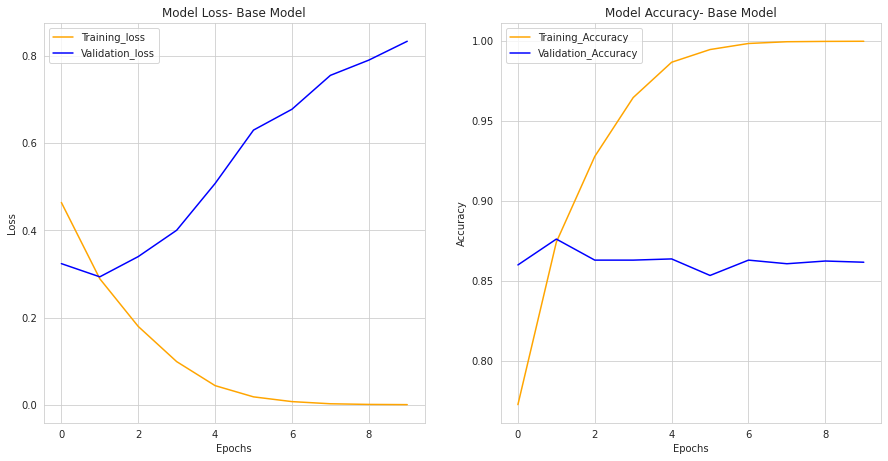

In [48]:
# fitting the Base model - Bidirectional LSTM 
start_time=time.time()
model.fit(X_train_bal, y_train_bal,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2)
et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds',end='\n\n')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss- Base Model')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy- Base Model')  

In [49]:
#evaluating the Base model - Bidirectional LSTM 
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)

# getting prediction values for X_test 
y_pred = model.predict(X_test, verbose=0).reshape(-1)

# setting threshold values and getting the transformed prediction output results
y_predict = (y_pred>0.5).astype(int)

# evaluating the model (using sklearn metrics)
accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# printing key metrics
print('*** Evaluation Results - Base Model***',end='\n\n')
print('Test Accuracy  :%0.2f' %(acc*100),'%',end='\n\n')
print('Classification Report:')
print(metrics.classification_report(y_test, y_predict),end='\n\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,y_predict),end='\n\n')
tn,fp,fn,tp = metrics.confusion_matrix(y_test,y_predict).reshape(-1)
print('True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews:',tn)
print('False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews:',fp)
print('False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews:',fn)
print('True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews:',tp)

# storing the model output in dataframe for comparison purpose
curmodeloutput = {'Model':'B-LSTM',
                  'Variant':'without tuning',
                  'Accuracy':accuracy_score,
                  'MCC':round(mcc,3),
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

df_result = df_result.append(curmodeloutput,ignore_index=True)

*** Evaluation Results - Base Model***

Test Accuracy  :86.17 %

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3062
           1       0.82      0.86      0.84      2259

    accuracy                           0.86      5321
   macro avg       0.86      0.86      0.86      5321
weighted avg       0.86      0.86      0.86      5321


Confusion Matrix:
[[2639  423]
 [ 313 1946]]

True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews: 2639
False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews: 423
False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews: 313
True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews: 1946


Key Observations:
1.   The model is performing extremely well on training set. 
2.   However the performance on validation (test data) is very poor. The validation loss is only going up with validation accuracy going down.
1.   Test validation accuracy is at 86.2% ( for Training accuracy of 99.9%) and this clearly shows the model is overfitting and needs to be regularized.



### Bi-directional LSTM classification Model - with Regularization



For regularization following 3 variants are evaluated:
1. Variant A: 1 separate Dropout layer enabled
2. Variant B: 1 Dropout and recurrent dropout inside LSTM and 1 separate dropout layer enabled
3. Variant C: 1 Dropout and recurrent dropout inside LSTM , l2 regularization and 1 separate dropout layer enabled


For all the regularization, callback options are enabled:
 - EarlyStopping - based on monitoring validation loss
 - Modelcheckpoint - based on monitoring validation accuracy
 - ReduceLR - based on monitoring validation accuracy















In [0]:
# other common parameters
EPOCHS = 50
PATIENCE = 5
FILENAME='myNLPmodelwt.h5'


#### Model Variant A - Bidirectional LSTM with regualization (using single Dropout layer)

In [51]:
# defining  model Variant A - Bidirectional LSTM with regualization (using single Dropout layer)

# clearing session and seeding randomness
clear_session()
np.random.seed(seed)
random.set_seed(seed)

# defining model variant A
model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid')) 

# compiling model variant A
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
model.compile(loss=loss,optimizer=optimizer, metrics=metrics_model)

print('Model Summary - Model Variant A',end='\n\n')
print(model.summary())

Model Summary - Model Variant A

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           4973600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)        

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.84533, saving model to myNLPmodelwt.h5
238/238 - 19s - loss: 0.5296 - accuracy: 0.7247 - val_loss: 0.3614 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.84533 to 0.86506, saving model to myNLPmodelwt.h5
238/238 - 18s - loss: 0.3921 - accuracy: 0.8224 - val_loss: 0.3162 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.86506
238/238 - 18s - loss: 0.3204 - accuracy: 0.8600 - val_loss: 0.3263 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 4/50

Epoch 00004: val_accuracy improved from 0.86506 to 0.87765, saving model to myNLPmodelwt.h5
238/238 - 18s - loss: 0.2682 - accuracy: 0.8901 - val_loss: 0.2867 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 5/50

Epoch 00005: val_accuracy did not improve from 0.87765
238/238 - 17s - loss: 0.2221 - accuracy: 0.9084 - val_loss: 0.2874 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 6/50

Epoch 00006: val_accuracy impr

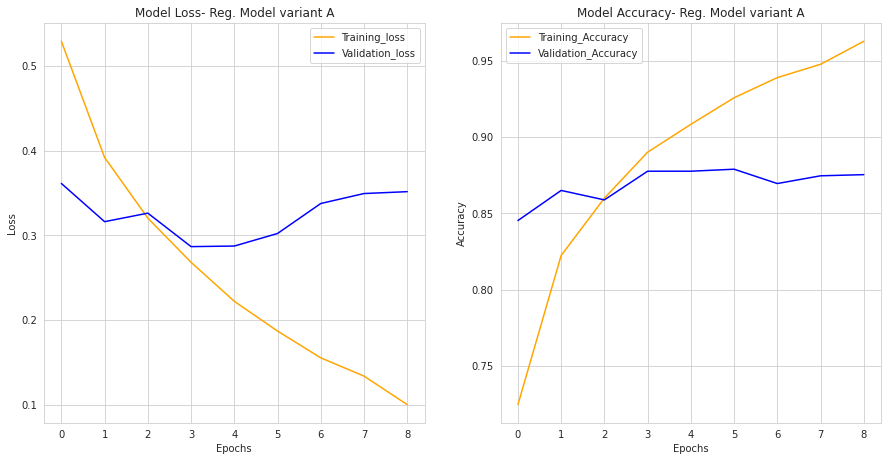

In [52]:
#fitting the model variant A  - with callback enabled
start_time=time.time()

checkpoint = ModelCheckpoint(FILENAME, monitor="val_accuracy", verbose=1, save_best_only=True,save_weights_only=True, mode="max", save_freq='epoch')
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="min",min_delta=.01)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2, min_lr=1e-6, verbose=0, mode="max")

model.fit(X_train_bal, y_train_bal,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2,callbacks=[stop,checkpoint,reduce_lr])

et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds',end='\n\n')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss- Reg. Model variant A')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy- Reg. Model variant A') 

In [53]:
# evaluating the model variant A
model.load_weights(FILENAME)
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)

# getting prediction values for X_test 
y_pred = model.predict(X_test, verbose=0).reshape(-1)

# setting threshold values and getting the transformed prediction output results
y_predict = (y_pred>0.5).astype(int)

# evaluating the model (using sklearn metrics)
accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# printing key metrics
print('*** Evaluation Results - Reg. Model variant A***',end='\n\n')
print('Test Accuracy  :%0.2f' %(acc*100),'%',end='\n\n')
print('Classification Report:')
print(metrics.classification_report(y_test, y_predict),end='\n\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,y_predict),end='\n\n')
tn,fp,fn,tp = metrics.confusion_matrix(y_test,y_predict).reshape(-1)
print('True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews:',tn)
print('False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews:',fp)
print('False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews:',fn)
print('True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews:',tp)

# storing the model output in dataframe for comparison purpose
curmodeloutput = {'Model':'B-LSTM',
                  'Variant':'Tuning_A',
                  'Accuracy':accuracy_score,
                  'MCC':round(mcc,3),
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

df_result = df_result.append(curmodeloutput,ignore_index=True)

*** Evaluation Results - Reg. Model variant A***

Test Accuracy  :87.90 %

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3062
           1       0.86      0.86      0.86      2259

    accuracy                           0.88      5321
   macro avg       0.88      0.88      0.88      5321
weighted avg       0.88      0.88      0.88      5321


Confusion Matrix:
[[2739  323]
 [ 321 1938]]

True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews: 2739
False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews: 323
False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews: 321
True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews: 1938


Key Observations:
1.   Validation curves are not as smooth as training curves
2.   The validation loss and accuracy shows movement in tandem with training initially, though beyond certain epoch, the validation loss and accuracy does not show improvement.
3.   The optimal model is at epoch 6 where training accuracy is at 92.6% and validation accuracy is at 87.9%.
4.   While from regularization standpoint, the model has clearly avoided overfitting, the overall validation accuracy is showing only marginal improvement from 86.2% to 87.9%.





#### Model Variant B - Bidirectional LSTM with regualization (using Dropout layers - in LSTM layer also)

In [54]:
# defining model Variant B - Bidirectional LSTM with regualization (using Dropout layers - in LSTM layer also)

# clearing session and seeding randomness
clear_session()
np.random.seed(seed)
random.set_seed(seed)

# defining model variant B
model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True,dropout=0.2, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid')) 

# compiling model variant B
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
model.compile(loss=loss,optimizer=optimizer, metrics=metrics_model)

print('Model Summary - Model Variant B',end='\n\n')
print(model.summary())

Model Summary - Model Variant B

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           4973600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)        

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.83856, saving model to myNLPmodelwt.h5
238/238 - 70s - loss: 0.5470 - accuracy: 0.7100 - val_loss: 0.3687 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.83856 to 0.86431, saving model to myNLPmodelwt.h5
238/238 - 69s - loss: 0.4133 - accuracy: 0.8099 - val_loss: 0.3194 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.86431 to 0.87333, saving model to myNLPmodelwt.h5
238/238 - 70s - loss: 0.3470 - accuracy: 0.8444 - val_loss: 0.3045 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 4/50

Epoch 00004: val_accuracy improved from 0.87333 to 0.87859, saving model to myNLPmodelwt.h5
238/238 - 68s - loss: 0.2976 - accuracy: 0.8735 - val_loss: 0.2885 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 5/50

Epoch 00005: val_accuracy improved from 0.87859 to 0.88141, saving model to myNLPmodelwt.h5
238/238 - 69s - loss: 0.2574 - accuracy: 0.8914 - val_loss: 0.2817 - va

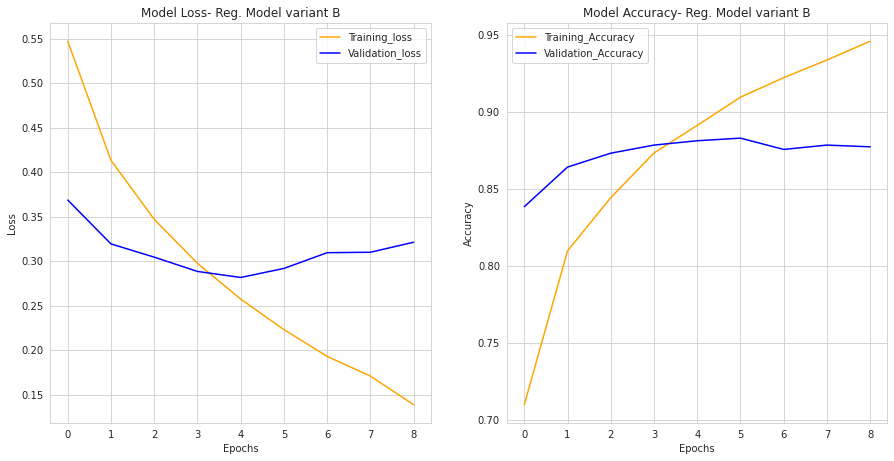

In [55]:
# fitting the model variant B - with callback enabled
start_time=time.time()

checkpoint = ModelCheckpoint(FILENAME, monitor="val_accuracy", verbose=1, save_best_only=True,save_weights_only=True, mode="max", save_freq='epoch')
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="min",min_delta=.01)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2, min_lr=1e-6, verbose=0, mode="max")

model.fit(X_train_bal, y_train_bal,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2,callbacks=[stop,checkpoint,reduce_lr])

et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds',end='\n\n')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss- Reg. Model variant B')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy- Reg. Model variant B') 

In [56]:
# evaluating the model variant B
model.load_weights(FILENAME)
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)

# getting prediction values for X_test 
y_pred = model.predict(X_test, verbose=0).reshape(-1)

# setting threshold values and getting the transformed prediction output results
y_predict = (y_pred>0.5).astype(int)

# evaluating the model (using sklearn metrics)
accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# printing key metrics
print('*** Evaluation Results - Reg. Model variant B***',end='\n\n')
print('Test Accuracy  :%0.2f' %(acc*100),'%',end='\n\n')
print('Classification Report:')
print(metrics.classification_report(y_test, y_predict),end='\n\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,y_predict),end='\n\n')
tn,fp,fn,tp = metrics.confusion_matrix(y_test,y_predict).reshape(-1)
print('True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews:',tn)
print('False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews:',fp)
print('False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews:',fn)
print('True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews:',tp)

# storing the model output in dataframe for comparison purpose
curmodeloutput = {'Model':'B-LSTM',
                  'Variant':'Tuning_B',
                  'Accuracy':accuracy_score,
                  'MCC':round(mcc,3),
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

df_result = df_result.append(curmodeloutput,ignore_index=True)

*** Evaluation Results - Reg. Model variant B***

Test Accuracy  :88.31 %

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3062
           1       0.86      0.86      0.86      2259

    accuracy                           0.88      5321
   macro avg       0.88      0.88      0.88      5321
weighted avg       0.88      0.88      0.88      5321


Confusion Matrix:
[[2756  306]
 [ 316 1943]]

True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews: 2756
False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews: 306
False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews: 316
True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews: 1943


Key Observations:
1.   Validation curves are not as smooth as training curves
2.   The validation loss and accuracy shows movement in tandem with training initially, though beyond certain epoch, the validation loss and accuracy does not show improvement.
3.   The optimal model is at epoch 6 where training accuracy is at 91% and validation accuracy is at 88.3%.
4.   While from regularization standpoint, the model has clearly avoided overfitting, the overall validation accuracy is showing only improvement from 86.2% to 88.3%.

#### Model Variant C - Bidirectional LSTM with regualization (using Dropout layers  and l2)

In [57]:
# defining model Variant C - Bidirectional LSTM with regualization (using Dropout layers  and l2)

# clearing the session and seeding randomness
clear_session()
np.random.seed(seed)
random.set_seed(seed)

# defining model variant C
model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid')) 

# compiling model variant C
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
model.compile(loss=loss,optimizer=optimizer, metrics=metrics_model)

print('Model Summary - Model Variant C',end='\n\n')
print(model.summary())

Model Summary - Model Variant C

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           4973600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)        

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.83067, saving model to myNLPmodelwt.h5
238/238 - 69s - loss: 3.6003 - accuracy: 0.6784 - val_loss: 1.9919 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.83067 to 0.84759, saving model to myNLPmodelwt.h5
238/238 - 69s - loss: 1.6727 - accuracy: 0.7876 - val_loss: 1.2606 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.84759
238/238 - 69s - loss: 1.0754 - accuracy: 0.8204 - val_loss: 0.8624 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 4/50

Epoch 00004: val_accuracy improved from 0.84759 to 0.85942, saving model to myNLPmodelwt.h5
238/238 - 69s - loss: 0.7232 - accuracy: 0.8402 - val_loss: 0.5819 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 5/50

Epoch 00005: val_accuracy improved from 0.85942 to 0.86130, saving model to myNLPmodelwt.h5
238/238 - 70s - loss: 0.5286 - accuracy: 0.8543 - val_loss: 0.4652 - val_accuracy: 0.8613 - lr: 0.0010
Epoch

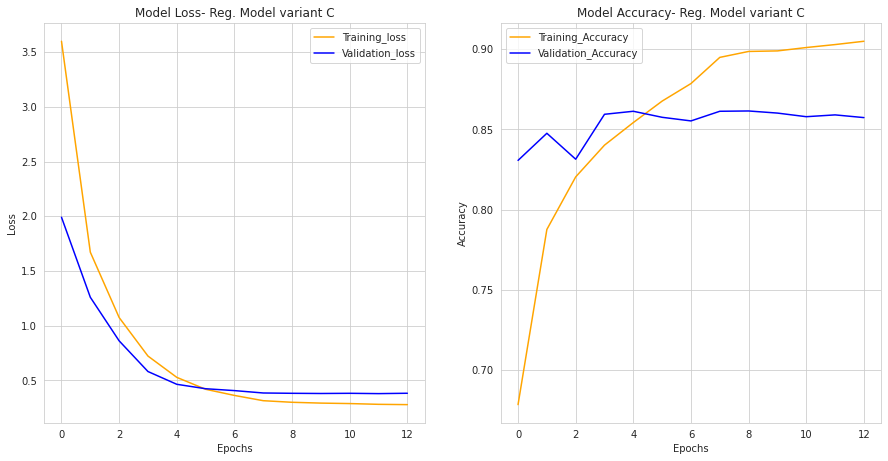

In [58]:
# fitting the model variant C - with callback enabled
start_time=time.time()
checkpoint = ModelCheckpoint(FILENAME, monitor="val_accuracy", verbose=1, save_best_only=True,save_weights_only=True, mode="max", save_freq='epoch')
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="min",min_delta=.01)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2, min_lr=1e-6, verbose=0, mode="max")

model.fit(X_train_bal, y_train_bal,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2,callbacks=[stop,checkpoint,reduce_lr])

et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds',end='\n\n')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss- Reg. Model variant C')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy- Reg. Model variant C') 

In [59]:
# evaluating the model variant C
model.load_weights(FILENAME)
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)


# getting prediction values for X_test 
y_pred = model.predict(X_test, verbose=0).reshape(-1)

# setting threshold values and getting the transformed prediction output results
y_predict = (y_pred>0.5).astype(int)

# evaluating the model (using sklearn metrics)
accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# printing key metrics
print('*** Evaluation Results - Reg. Model variant C***',end='\n\n')
print('Test Accuracy  :%0.2f' %(acc*100),'%',end='\n\n')
print('Classification Report:')
print(metrics.classification_report(y_test, y_predict),end='\n\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,y_predict),end='\n\n')
tn,fp,fn,tp = metrics.confusion_matrix(y_test,y_predict).reshape(-1)
print('True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews:',tn)
print('False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews:',fp)
print('False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews:',fn)
print('True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews:',tp)

# storing the model output in dataframe for comparison purpose
curmodeloutput = {'Model':'B-LSTM',
                  'Variant':'Tuning_C',
                  'Accuracy':accuracy_score,
                  'MCC':round(mcc,2),
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

df_result = df_result.append(curmodeloutput,ignore_index=True)

*** Evaluation Results - Reg. Model variant C***

Test Accuracy  :86.15 %

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3062
           1       0.81      0.88      0.84      2259

    accuracy                           0.86      5321
   macro avg       0.86      0.86      0.86      5321
weighted avg       0.86      0.86      0.86      5321


Confusion Matrix:
[[2596  466]
 [ 271 1988]]

True Negative - Actual Non sarcastic reviews prediced as Non sarcastic reviews: 2596
False Positive- Actual Non sarcastic reviews prediced as sarcastic reviews: 466
False Negative- Actual Sarcastic reviews prediced as Non sarcastic reviews: 271
True Positive - Actual Sarcastic reviews prediced as Sarcastic reviews: 1988


Key Observations:
1.   Validation accuracy curve is not as smooth as training curve, unlike the loss curves.
2.   The validation loss and accuracy shows movement in tandem with training initially, though beyond certain epoch, the validation loss and accuracy does not show improvement.
3.   The optimal model is at epoch 9 where training accuracy is at 89.9% and validation accuracy is at 86.1%.
4.   While from regularization standpoint, the model has clearly avoided overfitting, the overall validation accuracy has not improved  (from 86.2% to 86.1%).

### Comparison of Model evaluation metrices

In [60]:
df_result.style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()\
                    .highlight_max(axis=0)\
                    .format("{:.2%}",subset=['Accuracy','Class0-Precision','Sensitivity','Class0-F1','Class1-Precision','Specificity','Class1-F1'])

Model,Variant,Accuracy,MCC,CM,Class0-Precision,Sensitivity,Class0-F1,Class1-Precision,Specificity,Class1-F1
B-LSTM,without tuning,86.17%,0.719000,[[2639 423] [ 313 1946]],89.40%,86.19%,87.76%,82.14%,86.14%,84.10%
B-LSTM,Tuning_A,87.90%,0.752000,[[2739 323] [ 321 1938]],89.51%,89.45%,89.48%,85.71%,85.79%,85.75%
B-LSTM,Tuning_B,88.31%,0.761000,[[2756 306] [ 316 1943]],89.71%,90.01%,89.86%,86.39%,86.01%,86.20%
B-LSTM,Tuning_C,86.15%,0.720000,[[2596 466] [ 271 1988]],90.55%,84.78%,87.57%,81.01%,88.00%,84.36%


Summary:
1.   Regularization done in Variant B seems to be giving better results compared to other options in all parameters except 'Specificity' and 'Class 0 Precision'.
2.   The test dataset was not balanced (3009 class 0 vs 2312 class 1) and hence comparison of class level metrics is also important to evaluate the performance, in addition to accuracy.
3.   Variant B is scoring highest in 'Accuracy' and 'MCC' overall.
4.   At class level , metrics values are also highest in Variant B when compared to other options (except 'Specificity' and 'Class 0 Precision').
5.   If 'Specificity' is to be given more weightage, then variant C is better than other models.
6.   Overall Variant B is giving better results,even though overall regularization has not improved Accuracy values significantly.